----

#  !!!!! PLEASE CLICK ON TRUST NOTEBOOK BUTTON  !!!!!

---

# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [1]:
# Add your imports here
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as md

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql import dataframe
from pyspark.sql import functions as F
from pyspark.sql import DataFrameStatFunctions as statF
from pyspark.sql.functions import explode
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))


In [2]:
DATA_DIR = 'data/'

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

#### TASK A - loading data:

* load the dataset into a Spark dataframe, show the content, and save it in the Parquet format

In [3]:
# reading file directly as a spark df 
# /!\ the file Post_light.json contains only the first rows
posts = spark.read.json(DATA_DIR+'Posts.json');

In [4]:
posts.printSchema()

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



<span style="color:#00688B"> 
    Then, we store time in numeric format using timestamp assuming that the UTC offset is the same for all posts (i.e. +01:00 is the same for each post '2010-11-04T04:51:08.210+01:00').
<span>

In [5]:
# convert CreationDate to a more convenient form using unix_timestamp
posts = posts\
    .select(
        'Id', 'ParentId', 'PostTypeId', 'Score', 'Tags', 'ViewCount',
        F.unix_timestamp(posts.CreationDate, "yyyy-MM-dd'T'HH:mm:ss.SSS").alias('dt')
    )
print(posts.take(2))

[Row(Id=4020437, ParentId=None, PostTypeId=1, Score=0, Tags='<asp.net-mvc><jquery-ui>', ViewCount=510, dt=1288055875), Row(Id=4020438, ParentId=None, PostTypeId=1, Score=0, Tags='<javascript><html><css><dhtml>', ViewCount=62, dt=1288055897)]


In [6]:
# saving binary file to future uses
posts.write.mode('overwrite').parquet(DATA_DIR+"posts.parquet");

In [7]:
# loading the saved parquet files
posts = spark.read.parquet(DATA_DIR+"posts.parquet");

In [8]:
# getting RDDs in case of needs
posts_rdd = posts.rdd;
questions_rdd = posts_rdd.filter(lambda r: r['PostTypeId'] == 1)
answers_rdd = posts_rdd.filter(lambda r: r['PostTypeId'] == 2)

<span style="color:#00688B">
In task B we will express the questions in a more convenient form by splitting the tags into single tags. For now, we save the format as is.
</span>

#### TASK A.1 & A.2 : Number of questions and answers on StackOverflow


In [9]:
# loading counts
nQuestions = questions_rdd.count();
nAnswers   = answers_rdd.count();

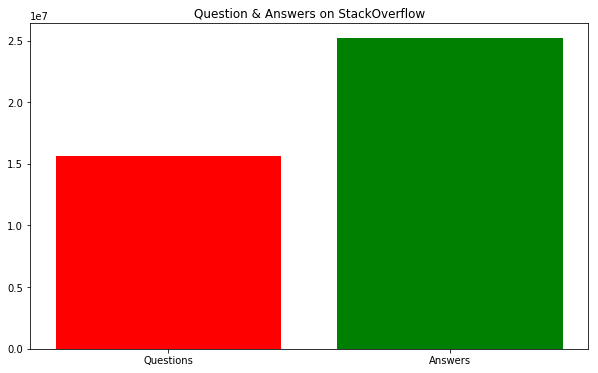

-- <u>**RESULTS**</u>: founded **15647060** questions and **25192772** answers

In [10]:
# and plot
fig, ax = plt.subplots(figsize=(10,6))
pm, pc = plt.bar(['Questions', 'Answers'],[nQuestions,nAnswers])
pm.set_facecolor('r')
pc.set_facecolor('g')
ax.set_title('Question & Answers on StackOverflow')

plt.show();

printmd('-- <u>**RESULTS**</u>: founded **'+ str(nQuestions) +'** questions and **'+ str(nAnswers)+'** answers');

#### TASK A.3 : % of question with score 0

<span style="color:#00688B">
    We filter the questions and select only those with a score of 0.
<span>

In [11]:
nQuestionsScore0 = questions_rdd.filter(lambda r: r['Score'] == 0).count();
percQScore0 = round(nQuestionsScore0/nQuestions,3);

printmd('-- <u>**RESULTS**</u>: founded **'+ str(nQuestionsScore0) +'** questions with score = 0: **' + str(percQScore0*100) + '%**');

-- <u>**RESULTS**</u>: founded **7282714** questions with score = 0: **46.5%**

**Hint:** Load the dataset from the Parquet file for the next tasks.

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

---
<span style="color:#00688B">
We create a new Spark DataFrame of questions by splitting the tags: each row of the original table that contained more than one tags, will be split into several rows, corresponding to each tag. In such way, we gain readability because we can easily query on each tag.
</span>

In [12]:
# create a DataFrame where we keep all the fields to answer the following questions (B,C,D)
postsTags = (posts.select('dt', 'Id', 'ParentId', 'PostTypeId','Score', 
                          'ViewCount', explode(F.split(posts.Tags, "><")).alias("Tags")
                         ).where('Tags != ""').withColumn('Tags', F.regexp_replace('Tags', '<|>', '')))

postsTags.show(5);

# saving binary question file to future uses
postsTags.write.mode('overwrite').parquet(DATA_DIR+"split_tags_questions.parquet");

+----------+--------+--------+----------+-----+---------+-----------------+
|        dt|      Id|ParentId|PostTypeId|Score|ViewCount|             Tags|
+----------+--------+--------+----------+-----+---------+-----------------+
|1401263000|23908091|    null|         1|   -3|      192|          android|
|1401263000|23908091|    null|         1|   -3|      192|sharedpreferences|
|1401263000|23908092|    null|         1|   -1|      234|               c#|
|1401263010|23908095|    null|         1|    0|       55|              php|
|1401263010|23908095|    null|         1|    0|       55|            mysql|
+----------+--------+--------+----------+-----+---------+-----------------+
only showing top 5 rows



#### TASK B.1 : tags that appears in fewer than 100 questions

In [13]:
tagsCounts = postsTags.groupby('Tags').count().select('Tags', F.col("count").alias("counts"))
tagsCounts.show(3)

+----------------+------+
|            Tags|counts|
+----------------+------+
|           input| 22045|
|    inappbrowser|   814|
|database-restore|   553|
+----------------+------+
only showing top 3 rows



In [14]:
# transform into Pandas DataFrame in order to plot afterwards
pdTagsCounts = tagsCounts.toPandas().set_index('Tags');
totalTagsCounts = int(pdTagsCounts.count());
maxTagsCounts = int(pdTagsCounts.max());

pdTagsCounts.head(5)

,counts
Tags,
input,22045
inappbrowser,814
database-restore,553
iframe,26125
standards,2495


**[work on spark dataframe]**

<span style="color:#00688B">
We group the questions by Tags and count the number of questions per tag. 
    
To find the tags that appear in less than 100 questions we apply a filter for less than 100 counts and then quantify the number of tags that fit the profile.
</span>

In [15]:
# filter for tags that appear in less than 100 questions
notPopularTags = tagsCounts.filter('counts < 100').count();
printmd('-- <u>**RESULTS**</u>: found **'+ str(notPopularTags) 
        +'** tags that appears in less than 100 questions (over '+ str(totalTagsCounts) + ' tags)');

-- <u>**RESULTS**</u>: found **36025** tags that appears in less than 100 questions (over 52994 tags)

#### TASK B.2 : Plot the distribution of the tag counts
<span style="color:#00688B">
    We plot the distribution of the tag counts using a histogram. We also do a zoom of the histogram to get a better view of the distribution. We plot the boxplots to get robust statistics and compare boxplots between the tag counts with outliers and tag counts without to see how the distribution is affected. 
<span>


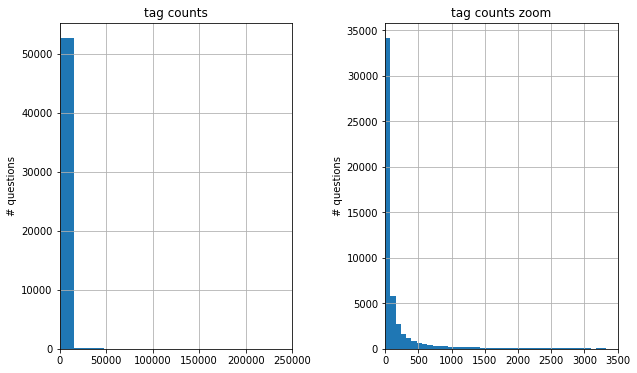

In [16]:
n_bins = [100, 20000]
xlim2 = [0,3500] 
xlim1 = [0, 250000]

f, ax1 = plt.subplots(1, 2, figsize=(10, 6))
f.subplots_adjust(wspace=0.4)
for ax, bin_, title in zip(ax1, n_bins, ['tag counts', 
                                         'tag counts' + ' zoom']):
    plt.sca(ax);
    pdTagsCounts.counts.hist(bins=bin_);
    plt.title(title);
    plt.ylabel('# questions');
    if ax == ax1[0]:
        ax.set_xlim(xlim1);
    if ax == ax1[1]:
        ax.set_xlim(xlim2);
plt.show()

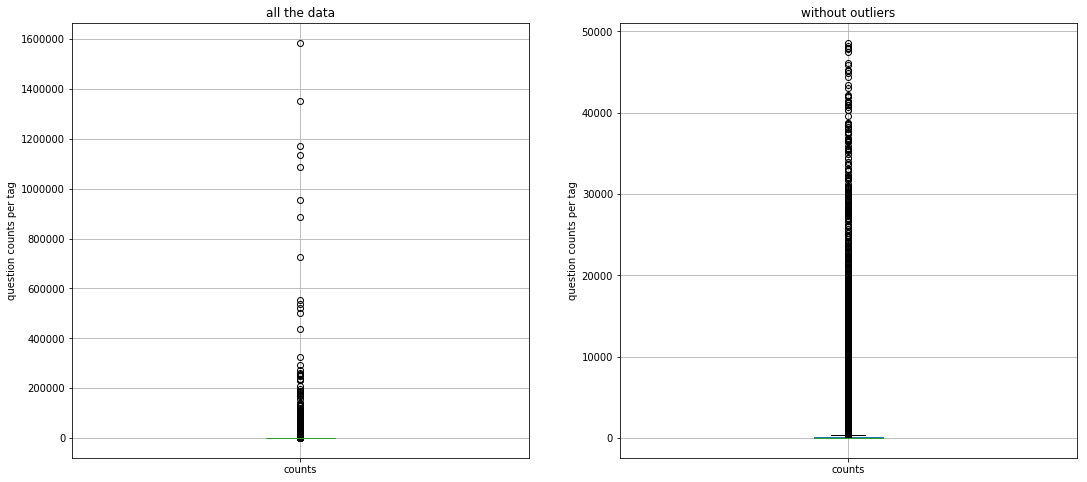

In [17]:
# exclude outliers
pdTagsCounts_cleaned = pdTagsCounts[
    np.abs(pdTagsCounts.counts-pdTagsCounts.counts.mean()) <= (3*pdTagsCounts.counts.std())
]

f, (ax1,ax2) = plt.subplots(1, 2);

plt.sca(ax1);
pdTagsCounts.boxplot();
plt.title('all the data');
plt.ylabel('question counts per tag');

plt.sca(ax2);
pdTagsCounts_cleaned.boxplot();
plt.title('without outliers');
plt.ylabel('question counts per tag');

f.set_size_inches(18, 8);

plt.show();

<span style="color:#00688B">
It seems that the distribution may follow a power law. To verify our suspicions, we plot our cumulative distribution in normal axes and in log-log axes. We look at a "cumulative distribution": how many tags have at least x questions?
    
<span>

In [18]:
# step coul be 1 but it will increase the execution time
step = 100;
xs = pd.Series(range(1,maxTagsCounts,step));
gratherThanData = xs.apply(lambda x: (pdTagsCounts.counts[pdTagsCounts.counts>=x]).count());

and plot

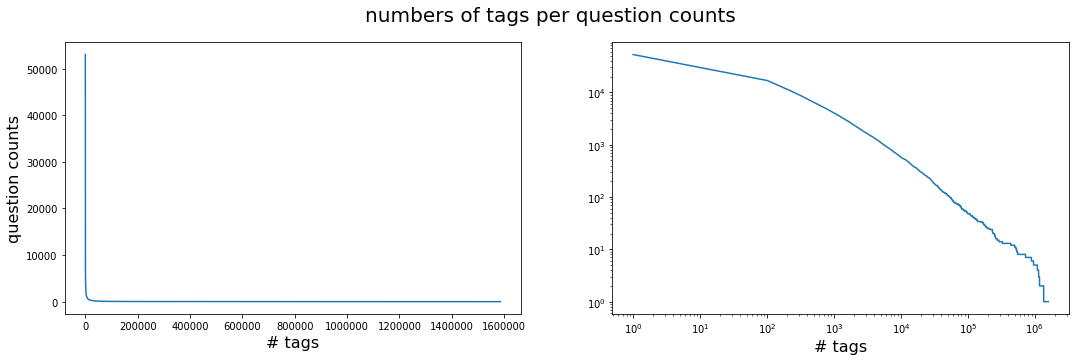

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2);
plt.sca(ax1);
plt.plot(xs,gratherThanData);
plt.ylabel('question counts',fontsize=16);
plt.xlabel('# tags',fontsize=16);

plt.sca(ax2);
plt.plot(xs,gratherThanData);
plt.xlabel('# tags',fontsize=16);
plt.yscale('log'); plt.xscale('log');


f.set_size_inches(18, 5)
f.suptitle('numbers of tags per question counts',fontsize=20)

plt.show();

#### TASK B.3 : bar chart 10 most popular tags
<span style="color:#00688B">
    We find the most popular tags by sorting the tag counts in descending fashion. And we plot in a bar chart the top 10 tags.
<span>

In [20]:
top10Tags = pdTagsCounts.sort_values(by="counts",ascending=False).head(10);
top10Tags

,counts
Tags,
javascript,1585495
java,1352735
c#,1172492
php,1136082
android,1088811
python,954401
jquery,886982
html,725289
ios,551843


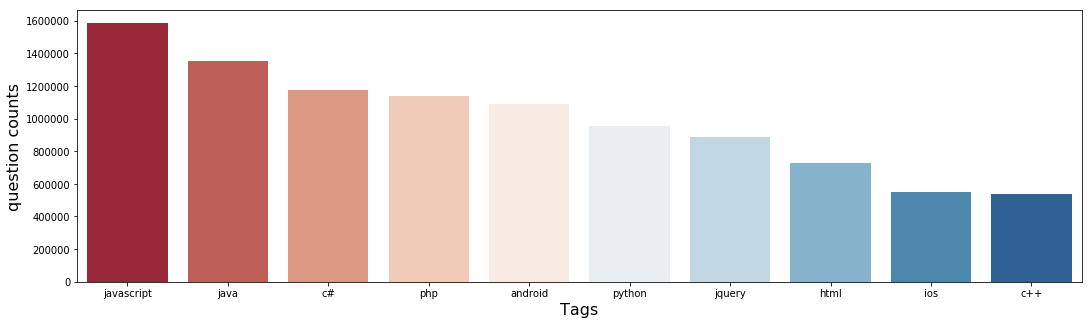

In [21]:
f, ax1 = plt.subplots();
plt.sca(ax1);
ax1 = sns.barplot(top10Tags.index, top10Tags.counts, data=top10Tags, palette="RdBu");
plt.ylabel('question counts',fontsize=16);
plt.xlabel('Tags',fontsize=16);
f.set_size_inches(18, 5)

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.

**Hint:** Inspect the data visually before drawing your conclusions.

In [22]:
# loading the saved parquet files
posts_C = spark.read.parquet(DATA_DIR+"split_tags_questions.parquet");

In [23]:
# create a table to query selecting just the questions (PostTypeId == 1)
questions_tags_table = posts_C.filter('PostTypeId == 1').registerTempTable('questions_tags_table') 

# select the ViewCount
query_c = """
select ViewCount, Score
from questions_tags_table
where Tags = 'random-effects'
"""
# TODO change tag from c to random-effects
result_c = spark.sql(query_c)
result_c.show(5)

+---------+-----+
|ViewCount|Score|
+---------+-----+
|      159|    1|
|       41|    1|
|      417|    7|
|      179|    0|
|      127|    1|
+---------+-----+
only showing top 5 rows



At the end of the pipeline, we still want our results in memory for further processing. Earlier in the course, we saw Pandas and the functionality it provides. Luckily, Spark provides a way to move from Spark DataFrames to Pandas ones almost seamlessly.

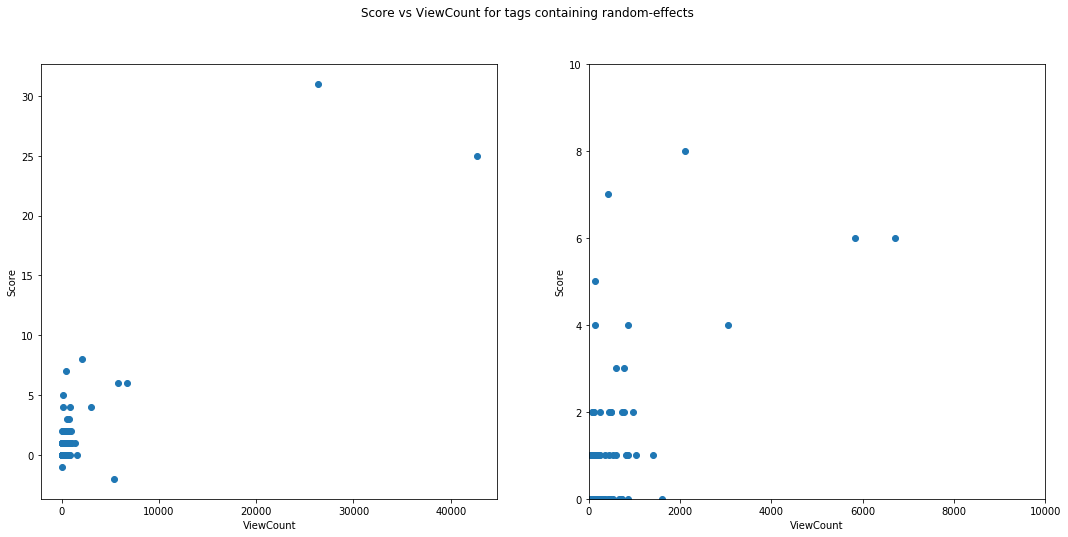

In [24]:
yr = result_c.toPandas()

# plot results
f, ax1 = plt.subplots(1, 2);
# TODO change axis lim
f.suptitle('Score vs ViewCount for tags containing random-effects')
ax1[0].scatter(yr.iloc[:, 0], yr.iloc[:, 1])
ax1[1].scatter(yr.iloc[:, 0], yr.iloc[:, 1])
ax1[1].set_xlim([0, 10000])
ax1[1].set_ylim([0, 10])
ax1[0].set_ylabel('Score')
ax1[1].set_ylabel('Score')
ax1[0].set_xlabel('ViewCount')
ax1[1].set_xlabel('ViewCount')

f.set_size_inches(18, 8);

plt.show();

In [25]:
print('Pearson correlation coefficient');
yr.corr(method='pearson')

Pearson correlation coefficient


,ViewCount,Score
ViewCount,1.000000,0.882197
Score,0.882197,1.000000


In [26]:
print('Spearman rank correlation');
yr.corr(method='spearman')

Spearman rank correlation


,ViewCount,Score
ViewCount,1.000000,0.463951
Score,0.463951,1.000000


<span style="color:#00688B">
Are the variables correlated?
</span>

---

**Visualization.** <span style="color:#00688B"> To relate the two variables </span> `ViewCount` and `Score`, we use a scatter plot to analyse visually their relationship. We can see that the variables are independent as `Score` is independent of `ViewCount`: for a Score of 2 you can have `ViewCount` that ranges from 0 to 2000 roughly.

**Pearsonʼs Correlation Coefficient** <span style="color:#00688B"> tells us if 2 variables are related in linear fashion. </span>  When computing the Pearson correlation coefficient of `ViewCount` and `Score`, we obtain 0.88 which is completely wrong if we take a visual look at the data. Pearson correlation coefficient can be misleading.

**Spearman Rank Correlation** <span style="color:#00688B"> shows if there is a monotonic relationship between </span> `ViewCount` and `Score`. We compute the Spearman rank correlation to confront it to the results we obtain with Pearson correlation coefficient. We obtain a Spearman rank correlation of 0.46, which shows that indeed the variables `ViewCount` and `Score` are not correlated.

**Take-home message**:  <span style="color:#00688B"> always inspect visually the data before drawing any kind of conclusions! </span> Especially with *Pearsonʼs Correlation Coefficient*

---

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


<span style="color:#00688B">
We first filter posts containing only 'python' or 'java' to reduce cardinality. We also later create an SQL view table
</span>

In [27]:
# loading the saved parquet files
questions_posts_D = spark.read.parquet(DATA_DIR+"split_tags_questions.parquet");
answers_posts_D = spark.read.parquet(DATA_DIR+"posts.parquet");

In [28]:
# java and python questions with converted time stamp 
questions_D = questions_posts_D\
    .filter("Tags = 'python' OR Tags = 'java'")\
    .select(
        'Id', 'ParentId', 'PostTypeId', 'Tags', 'dt'
    )
print(questions_D.take(2))
print('\n')

# java and python answers with converted time stamp 
answers_D = answers_posts_D\
    .filter("PostTypeId = 2")\
    .select(
        'Id', 'ParentId', 'PostTypeId', 'dt'
    )
print(answers_D.take(2))

[Row(Id=37848248, ParentId=None, PostTypeId=1, Tags='python', dt=1466031962), Row(Id=37848290, ParentId=None, PostTypeId=1, Tags='java', dt=1466032243)]


[Row(Id=23908093, ParentId=23907336, PostTypeId=2, dt=1401263009), Row(Id=23908094, ParentId=23871886, PostTypeId=2, dt=1401263009)]


In [29]:
# Create a SQL view for both answers and quewstions
questions_D_table = questions_D.registerTempTable('questions_D_table')
answers_D_table = answers_D.registerTempTable('answers_D_table')

 ---
### D1. Response time for the first answer of the questions with the tags python and java.

<span style="color:#00688B">
We assume there are no answers that have exactly the same time stamp for the same question (at millisec precision). We preformed as nested query. 
    
    In the inner query, we grouped the answers by parentId and selected the answer having min time stamp. We then inner-joined the outer table on ParentId and computed the response time as the difference between the time stamp of the answer and the time stamp of the question.
</span>

In [30]:
# for python
query_first_ans_python = """
select qst.Id, qst.dt, ans.min_dt, (ans.min_dt - qst.dt) as response_time
from questions_D_table as qst, (
                        select ParentId, min(dt) as min_dt
                        from answers_D_table
                        group by ParentId) as ans
where ans.ParentId = qst.Id and qst.Tags = 'python'
"""

result_d_first_ans_python = spark.sql(query_first_ans_python)
print(result_d_first_ans_python.show(4))

# for java
query_first_ans_java = """
select qst.Id, qst.dt, ans.min_dt, (ans.min_dt - qst.dt) as response_time
from questions_D_table as qst, (
                        select ParentId, min(dt) as min_dt
                        from answers_D_table
                        group by ParentId) as ans
where ans.ParentId = qst.Id and qst.Tags = 'java'
"""

result_d_first_ans_java = spark.sql(query_first_ans_java)
print(result_d_first_ans_java.show(4))

+------+----------+----------+-------------+
|    Id|        dt|    min_dt|response_time|
+------+----------+----------+-------------+
| 39104|1220341226|1220348625|         7399|
| 92620|1221738082|1221743171|         5089|
|116139|1222096092|1222096603|          511|
|181556|1223440461|1223441217|          756|
+------+----------+----------+-------------+
only showing top 4 rows

None
+-----+----------+----------+-------------+
|   Id|        dt|    min_dt|response_time|
+-----+----------+----------+-------------+
|30428|1219843291|1219845213|         1922|
|37310|1220222403|1220222842|          439|
|55709|1221093612|1221093902|          290|
|79662|1221614943|1221615099|          156|
+-----+----------+----------+-------------+
only showing top 4 rows

None


---
### D2. Plot distribution of first response

Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation

In [31]:
# convert into pd DataFrames selecting only Id and response_time
# python
first_ans_python_pd = result_d_first_ans_python.select('Id', 'response_time').toPandas().set_index('Id')

# java
first_ans_java_pd = result_d_first_ans_java.select('Id', 'response_time').toPandas().set_index('Id')

<span style="color:#00688B">
We remove wrong values of response time: i.e response times < 0
</span>

In [32]:
# remove wrong values of response time i.e. response times smaller than 0
shapes_before = [first_ans_python_pd.shape[0], first_ans_java_pd.shape[0]]
first_ans_java_pd = first_ans_java_pd[first_ans_java_pd.response_time > 0]
first_ans_python_pd = first_ans_python_pd[first_ans_python_pd > 0]
print('Nb of Python response times after having removed smaller than 0 values: {}'.format(
    shapes_before[0]- first_ans_python_pd.shape[0])
     )

print('Nb of Java response times after having removed smaller than 0 values: {}'.format(
    shapes_before[1] - first_ans_java_pd.shape[0])
     )

Nb of Python response times after having removed smaller than 0 values: 0
Nb of Java response times after having removed smaller than 0 values: 2252


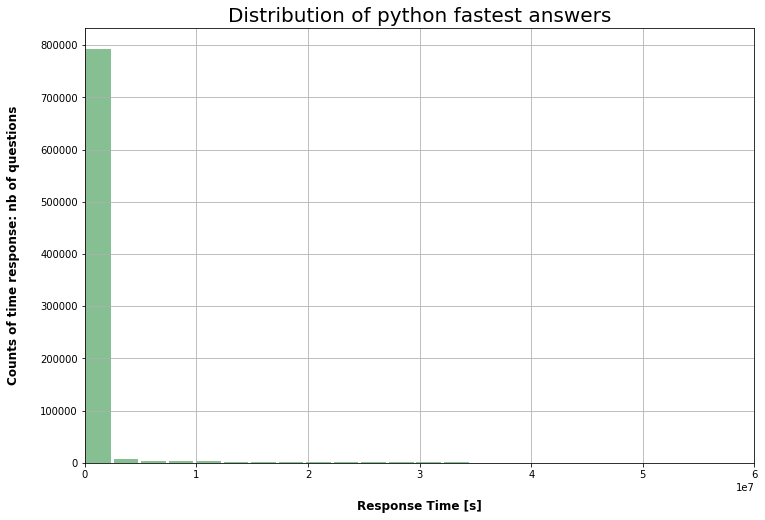

In [33]:
ax = first_ans_python_pd.hist(
    bins=100, grid=True,
    figsize=(12,8), color='#86bf91', rwidth=0.9)

ax = ax[0]
for x in ax:
    # Remove title
    x.set_title("Distribution of python fastest answers", fontdict={'fontsize':20})

    # Set x-axis label
    x.set_xlabel("Response Time [s]", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Counts of time response: nb of questions", labelpad=20, weight='bold', size=12)
    x.set_xlim([0,0.6e8])


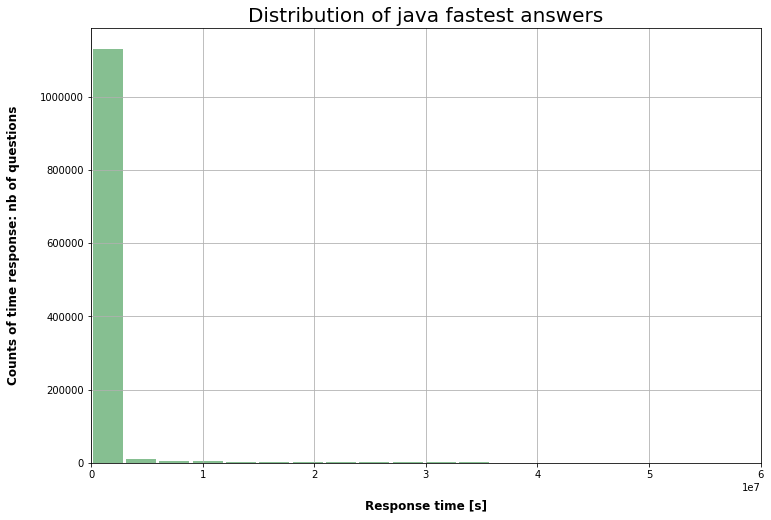

In [34]:
# java
ax = first_ans_java_pd.hist(
    bins=100, grid=True,
    figsize=(12,8), color='#86bf91', rwidth=0.9)

ax = ax[0]
for x in ax:
    # Remove title
    x.set_title("Distribution of java fastest answers", fontdict={'fontsize':20})

    # Set x-axis label
    x.set_xlabel("Response time [s]", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Counts of time response: nb of questions", labelpad=20, weight='bold', size=12)
    x.set_xlim([0,0.6e8])

In [35]:
# compute quantiles
first_ans_python_pd.describe().iloc[3:].T

,min,25%,50%,75%,max
response_time,1.0,425.0,1357.0,9583.0,246457525.0


In [36]:
first_ans_java_pd.describe().iloc[3:].T

,min,25%,50%,75%,max
response_time,1.0,396.0,1224.0,9615.0,298536705.0


<span style="color:#00688B">
At first glance, the histograms depicting the distribution of the response time for the first answer of the questions with the tags python and java seem to to be heavy-tailed distributions: they may follow a power law. To recognize if the distirbutions follow a power law, we plot the data in log-log axes. If they follow a power law, reporting mean or variance for a power-law-distributed data is not relevant as these statistics are not robust as they are sensitive to data. Instead, we use robust statistics and report the median and quartiles using boxplots. We compare boxplots with and without outliers.
</span>

**Python & Java Boxplots**

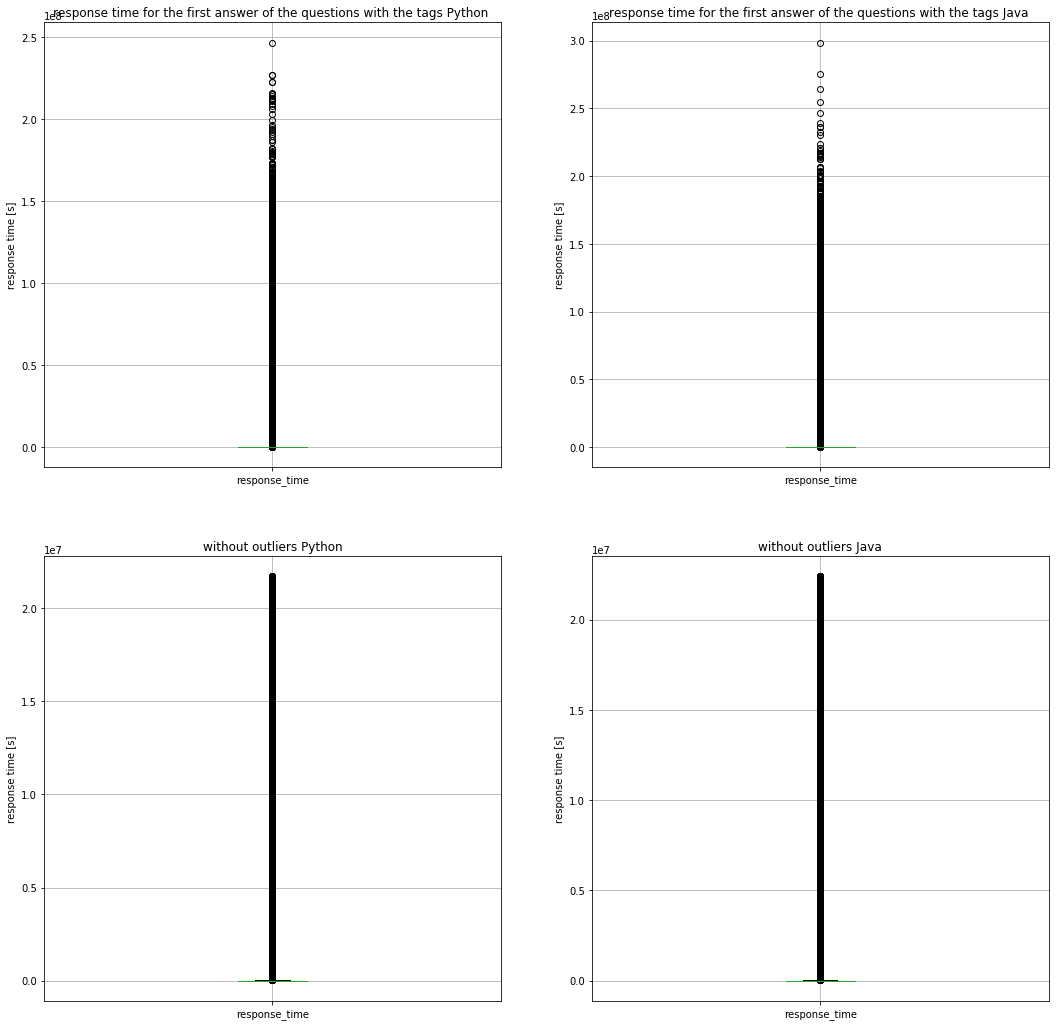

In [37]:
# exclude outliers
first_ans_python_pd_no_outliers = first_ans_python_pd[
    np.abs(first_ans_python_pd-first_ans_python_pd.mean()) <= (3*first_ans_python_pd.std())
]

first_ans_java_pd_no_outliers = first_ans_java_pd[
    np.abs(first_ans_java_pd-first_ans_java_pd.mean()) <= (3*first_ans_java_pd.std())
]


f, (ax1,ax2) = plt.subplots(2, 2);

plt.sca(ax1[0]);
first_ans_python_pd.boxplot();
plt.title('response time for the first answer of the questions with the tags Python ');
plt.ylabel('response time [s]');

plt.sca(ax1[1]);
first_ans_java_pd.boxplot();
plt.title('response time for the first answer of the questions with the tags Java ');
plt.ylabel('response time [s]');

plt.sca(ax2[0]);
first_ans_python_pd_no_outliers.boxplot();
plt.title('without outliers Python');
plt.ylabel('response time [s]');

plt.sca(ax2[1]);
first_ans_java_pd_no_outliers.boxplot();
plt.title('without outliers Java');
plt.ylabel('response time [s]');

f.set_size_inches(18, 18);

plt.show();

In [55]:
# step coul be 1 but it will increase the execution time
# we didnt manage to have a spark dataframe, so it will be slow
def compute_like_cumulative_distribution(the_serie, step=100):
    if isinstance(the_serie, pd.Series):
        max_serie = int(the_serie.max())
        xs = pd.Series(range(1,max_serie,step));
        gratherThanData = xs.apply(lambda x: (the_serie[the_serie>=x]).count());
        return xs, gratherThanData
    else:
        raise TypeError('the_serie must be a pandas series not a {}'.format(type(the_serie)))

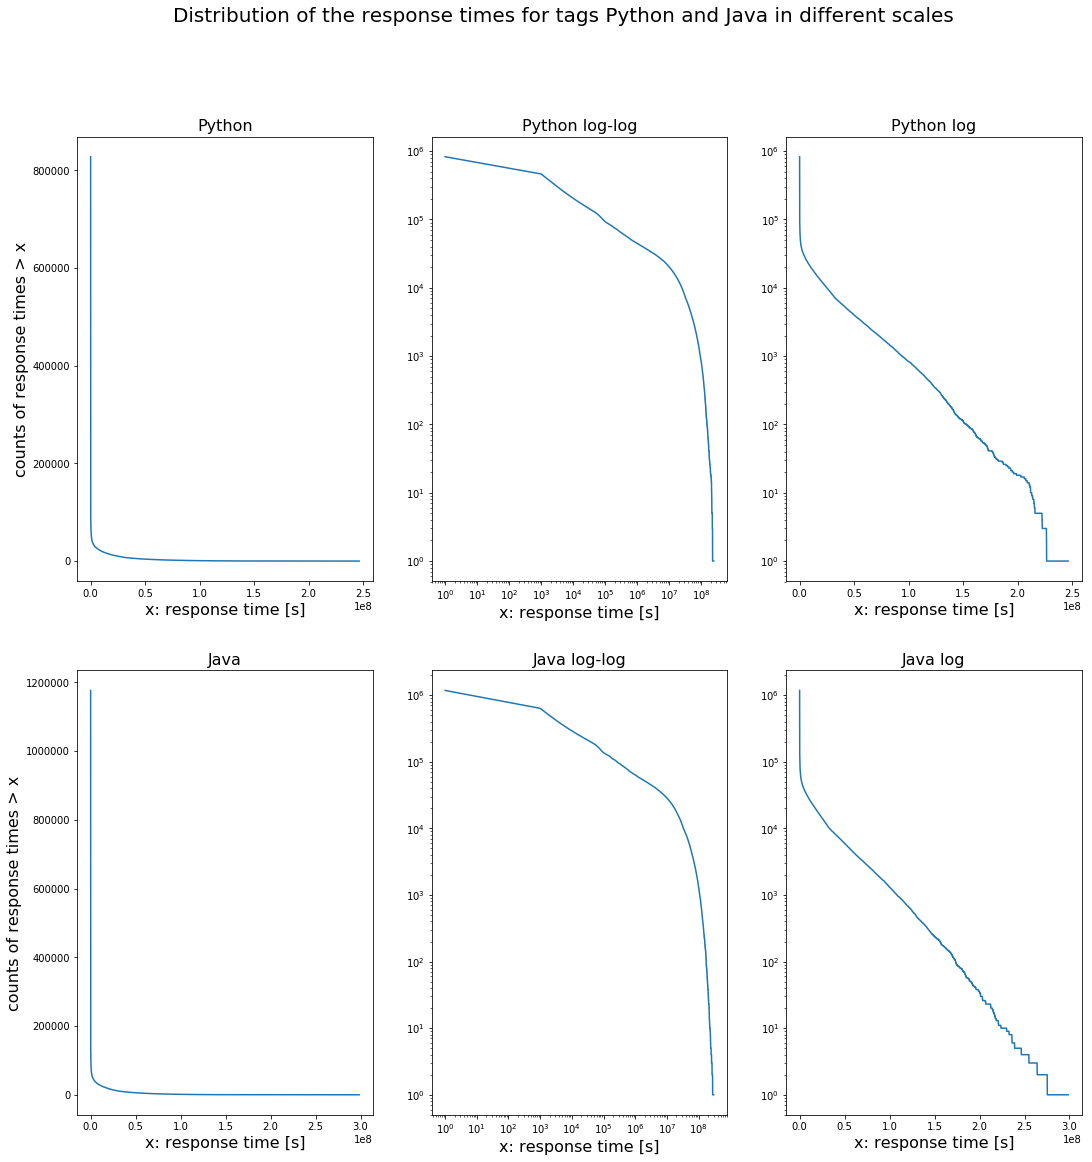

In [56]:
# TODO is it correct??
xs_python, cumulative_python = compute_like_cumulative_distribution(first_ans_python_pd.response_time, step=1000)
xs_java, cumulative_java = compute_like_cumulative_distribution(first_ans_java_pd.response_time, step=1000)

f, axs = plt.subplots(2, 3);

for ax, xs, distr, tag in zip(axs, [xs_python, xs_java], [cumulative_python, cumulative_java], ['Python', 'Java']):
    plt.sca(ax[0]);
    plt.plot(xs,distr);
    plt.ylabel('counts of response times > x',fontsize=16);
    plt.xlabel('x: response time [s]',fontsize=16);
    plt.title('{}'.format(tag), fontsize=16)

    plt.sca(ax[1]);
    plt.plot(xs,distr);
    plt.xlabel('x: response time [s]',fontsize=16);
    plt.yscale('log'); plt.xscale('log');
    plt.title('{} log-log'.format(tag), fontsize=16)

    plt.sca(ax[2]);
    plt.plot(xs,distr);
    plt.xlabel('x: response time [s]',fontsize=16);
    plt.yscale('log')
    plt.title('{} log'.format(tag), fontsize=16)

    
f.set_size_inches(18, 18)
f.suptitle('Distribution of the response times for tags Python and Java in different scales',fontsize=20)

plt.show();

**Description of our findings and discussion about the following distribution properties: mean, median, standard deviation.

<span style="color:#00688B">
By looking at the plots: counts of response times > x, we can see that distribution of the response time for the first answer of the questions with the tags python and java seem to to be heavy-tailed distributions: they may follow a power law. To recognize if the distirbutions follow a power law, as said before, we plot the data in log-log axes: they seem to follow a power law as the log-log plot looks like a line with a very long tail. 
     We plot also in log(y)-x scale to check if it may follow a exponential law, but this hypothesis is discarded by visualizing the plots.
    
   Since they follow a power law, reporting mean or variance for a power-law-distributed data is not relevant as these statistics are not robust as they are sensitive to data. Instead, we used robust statistics and report the median and quartiles using boxplots as shown above. 
</span>

---
### D3. Boostrapping

3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.

<span style="color:#00688B">
From previous plots and analyses, we use the median as statistic to bootstrap the median. If the two medians (Python and Java) of the response time are different, then there is a statistically difference in the response time at level of 95%
    
   We decide to perform bootstrap to determine if there is really a difference in response time for questions related to Python in comparison to Java :
      *No difference in medians* : difference of medians = 0
      *Difference in medians* : difference of medians ≠ 0
</span>

In [42]:
def bootstrap_differences_median(spark_df1_1col, spark_df2_1col, nb_folds=30, seed=16):
    if all([isinstance(df, dataframe.DataFrame) for df in [spark_df1_1col, spark_df2_1col]]):   
        if all([len(df.columns) == 1 for  df in [spark_df1_1col, spark_df2_1col]]):
            differences_median = []
            for fold in range(nb_folds):
                # sample with replacement with uniform probability
                resampled1 = spark_df1_1col.sample(True, 1.0, seed)
                resampled2 = spark_df2_1col.sample(True, 1.0, seed)
                
                # compute the difference between the mediansfor the subgroup
                median1 = resampled1.approxQuantile('response_time', [0.5], 0.25)[0] # compute the median of df1
                median2 = resampled1.approxQuantile('response_time', [0.5], 0.25)[0] # compute the median of df2
                differences_median.append(median1 - median2)

            return differences_median
        else:
            raise ValueError('must have a single column not {}'.format(len(spark_dataframe_1_col)))
        raise TypeError(
            'spark_df1_1col, spark_df2_1col must be apyspark.sql.dataframe.DataFrame not a {} / '.format(
                type(spark_dataframe_1_col)))

<span style="color:#00688B">
This function takes as argument 2 spark dataframes and computes bootstrapped estimation of the difference between medians over each fold: 
    
    for each fold:
        1. bootstrap samples for each tag: sample with replacement with uniform probability
        2. compute the median of bootstrap samples for each tag
        3. compute the difference between the 2 medians of each tag
    
</span>

In [43]:
# selected the response_time of the fastest response for Python and Java
python_responses = result_d_first_ans_python.select('response_time')
java_responses = result_d_first_ans_java.select('response_time')

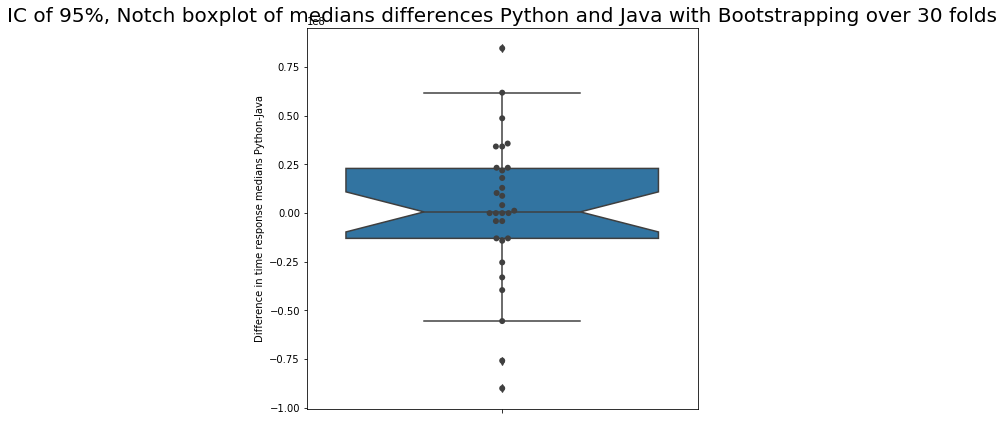

In [44]:
python_minus_java_medians = bootstrap_differences_median(python_responses, java_responses) # 30 folds by default
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(python_minus_java_medians, notch=True, orient='v', ax=ax)
sns.swarmplot(python_minus_java_medians, color='0.25', size=6, orient='v', ax=ax)
plt.title('IC of 95%, Notch boxplot of medians differences Python and Java with Bootstrapping over 30 folds', 
          fontdict={'fontsize':20})
plt.ylabel('Difference in time response medians Python-Java')
plt.show()

<span style="color:#00688B">
We estimated the proper statistic (difference in time response medians) with bootstrapping over 30 folds.
Since the 0 is comprised within the 95% confidence interval, it seems that there is no significant difference between the time response medians of Python and Java at such a significance level. Therefore, the response time is not lower for questions related to Python in comparison to Java. 
</span>

---
### D4
Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.

In [45]:
# reload questions and answers: loading the saved parquet files
questions_posts_D4 = spark.read.parquet(DATA_DIR+"split_tags_questions.parquet");
answers_posts_D4 = spark.read.parquet(DATA_DIR+"posts.parquet");

In [46]:
# questions with converted time stamp 
questions_D4 = questions_posts_D4\
    .select(
        'Id', 'ParentId', 'PostTypeId', 'Tags', 'dt'
    )
print(questions_D4.take(2))
print('\n')

# answers with converted time stamp 
answers_D4 = answers_posts_D4\
    .filter("PostTypeId = 2")\
    .select(
        'Id', 'ParentId', 'PostTypeId', 'dt'
    )
print(answers_D4.take(2))

[Row(Id=37848204, ParentId=None, PostTypeId=1, Tags='scala', dt=1466031592), Row(Id=37848204, ParentId=None, PostTypeId=1, Tags='apache-spark', dt=1466031592)]


[Row(Id=23908093, ParentId=23907336, PostTypeId=2, dt=1401263009), Row(Id=23908094, ParentId=23871886, PostTypeId=2, dt=1401263009)]


In [47]:
# Create a SQL view for both answers and quewstions
questions_D4_table = questions_D4.registerTempTable('questions_D4_table')
answers_D4_table = answers_D4.registerTempTable('answers_D4_table')

***Query to find the response time for the tags that appear at least 5000 times and 10 tags with the fastest response time ***

<span style="color:#00688B">
We have a nested query. In the inner query, we group by tags selecting tags having at least 5000 appearances.
In the outer query, we compute the median over the response times grouped by Tag. 
The response times are found by an inner join with the questions table on ParentId = Id and
response time is computed as the difference between both times. We then select the top 10 tags based on the time response: by ordering the tags by response time in ascending fashion and limit to 10.   
</span>

In [48]:
# group by tags and select only those that have >= 5000 appearances and inner join with answers on ParentId = Id
query_D4 = """
select qst4.Tags, percentile_approx(ans4.dt-qst4.dt, 0.5) as median
from questions_D4_table as qst4, answers_D4_table as ans4
where qst4.Id = ans4.ParentId 
and qst4.Tags in  (select quest.Tags
                    from questions_D4_table as quest
                    group by quest.Tags
                    having count(*) >= 5000)
group by qst4.Tags
order by median asc
limit 10
"""

result_query_tags_5000 = spark.sql(query_D4)
print(result_query_tags_5000.show())

+----------------+------+
|            Tags|median|
+----------------+------+
|jquery-selectors|   450|
|          return|   601|
|             int|   642|
|            char|   649|
|    syntax-error|   654|
|     constructor|   655|
|   css-selectors|   656|
|          syntax|   670|
|    if-statement|   683|
|        pointers|   689|
+----------------+------+

None


In [49]:
# transform to pandas
top10_tags_response_pd = result_query_tags_5000.toPandas().set_index('Tags')

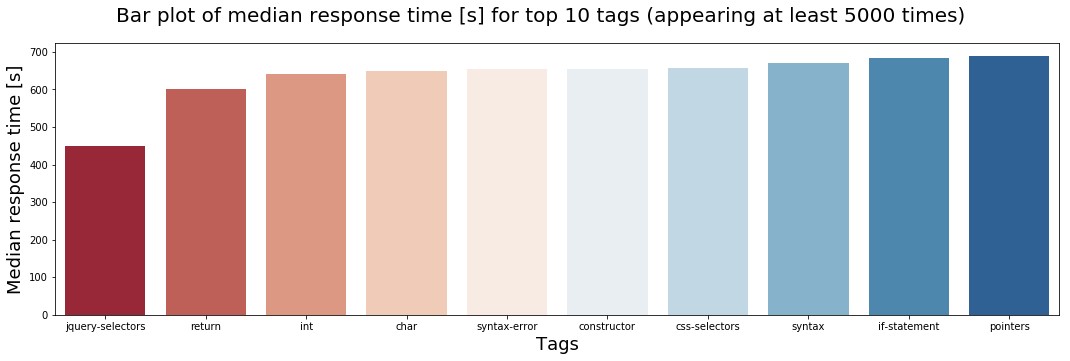

In [50]:
# plot using bar plot: median response time [s] for top 10 tags (appearing at least 5000 times)
f, ax1 = plt.subplots()
plt.sca(ax1)
sns.barplot(top10_tags_response_pd.index, top10_tags_response_pd['median'], palette="RdBu", ax=ax1)
plt.ylabel('Median response time [s]',fontsize=18)
plt.xlabel('Tags',fontsize=18)
f.suptitle('Bar plot of median response time [s] for top 10 tags (appearing at least 5000 times)', fontsize=20)
f.set_size_inches(18, 5)
plt.show()

<span style="color:#00688B">
 Interestingly, the easiest problems such as return, int, char have the fastest median response time [s].   
<span>

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?


---
<span style="color:#00688B">
First we filter the questions to select only the pyspark related questions that are posted after the 26 may 2014 </span> 

([release of pyspark).](https://github.com/apache/spark/releases/tag/v1.0.0)
    
<span style="color:#00688B"> 
    We discretize the questions related to `pyspark` by bins of 30 days. In order to do that, we find the min and the max of the spark DataFrame where the unix_timestamps are converted into days (instead of seconds). The the number of bins required is defined as:
</span>

\begin{equation*}
bins  = \lceil \frac{max - min}{30} \rceil
\end{equation*}

In [3]:
# load questions from parquet file
questions_E = spark.read.parquet(DATA_DIR+"split_tags_questions.parquet");

In [4]:
# TODO change tags to 'pyspark'
day_conversion = 24 * 60**2 # one day is: 60 sec * 60 hours * 24 hours

# filter to take only pyspark questions after the 26 may 2014 (release of pyspark)
questions_E = questions_E\
    .filter("Tags = 'pyspark' AND dt>'1401098400'")\
    .withColumn('dt_days', questions_E.dt/day_conversion)\
    .select('dt_days')
print(questions_E.take(2))
print('\n')

[Row(dt_days=16968.06931712963), Row(dt_days=16968.231527777778)]




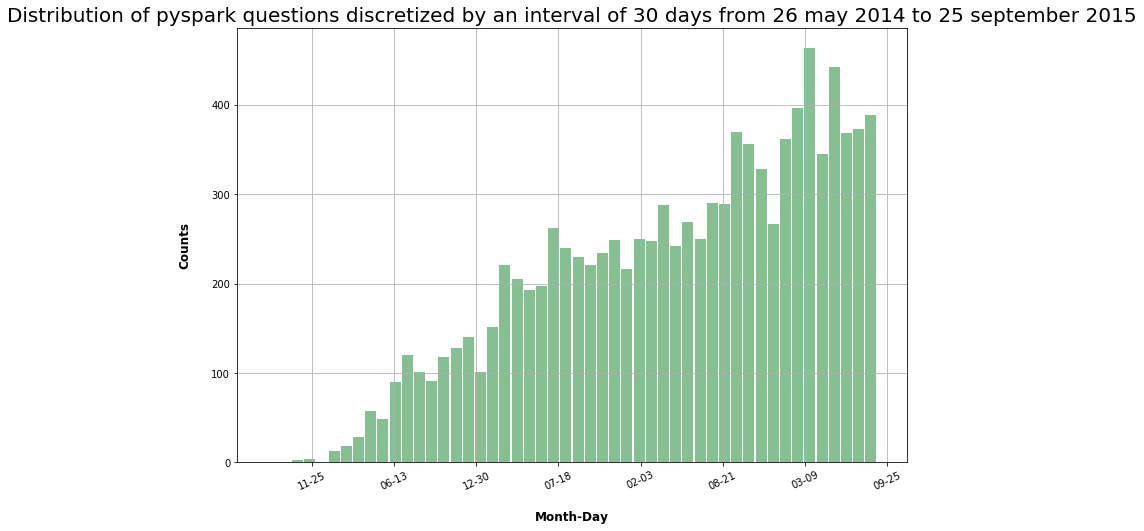

In [6]:
# construct bins: 1 + (max - min)/30
# first create a SQL view to find the range
E_table = questions_E.registerTempTable("E_table")
# find max and min
max_day = spark.sql("SELECT MAX(dt_days) as maxval FROM E_table").collect()[0].asDict()['maxval']
min_day = spark.sql("SELECT MIN(dt_days) as minval FROM E_table").collect()[0].asDict()['minval']
# define the nb of bins
the_bins = 1 + int((max_day - min_day)/30)

# discretize questions according to the bins
ax = questions_E.toPandas().hist(
    bins=the_bins, grid=True,
    figsize=(12,8), color='#86bf91', rwidth=0.9)

ax = ax[0]
for x in ax:
    x.set_title(
        "Distribution of pyspark questions discretized by an interval of 30 days from 26 may 2014 to 25 september 2015"
        , fontdict={'fontsize':20})

    # Set x-axis label
    x.set_xlabel("Month-Day", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Counts", labelpad=20, weight='bold', size=12)
    
    # convert now unix_timstamp
    plt.xticks( rotation=25 )
    xfmt = md.DateFormatter('%m-%d')
    x.xaxis.set_major_formatter(xfmt)

<span style="color:#00688B">
Seems a linear correlation between the number of questions about pyspark and the days. Between 13th march and 9th september 2015, there were 3 spark releases: spark 1.3, spark 1.4,  spark 1.5. "Spark 1.4 was one of the largest release ever, with contributions from 210 developers and more than 1,000 commits! And 1.5 largest release ever, with contributions from 230 developers and more than 1,400 commits" This correlates with the high pick between 13th march and 9th september 2015.
</span> 